## Session-Based Product Recommendation System

This notebook implements a basic session-based product recommendation pipeline using machine learning models.
We process clickstream data, extract session-level features, and apply classification algorithms to predict the most likely product a user might interact with in a session.


### Data Loading and Preprocessing

We begin by importing the necessary libraries and loading the dataset.  
Data cleaning and feature engineering steps are applied to prepare the input for machine learning models.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [5]:
# Load the datasets
item_properties_part1 = pd.read_csv("item_properties_part1.csv")
item_properties_part2 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")
events = pd.read_csv("events.csv")

In [6]:
item_properties_part1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [7]:
item_properties_part2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [8]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [9]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [10]:
# Merge item property datasets
item_properties = pd.concat([item_properties_part1, item_properties_part2])

# Convert timestamp to datetime for easier time-based filtering
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

# Simplify properties for now by keeping categoryid only
item_cat = item_properties[item_properties['property'] == 'categoryid']
item_cat = item_cat[['itemid', 'value']].rename(columns={'value': 'categoryid'})
item_cat = item_cat.drop_duplicates('itemid')

In [11]:
# Merge categoryid into events
events = pd.merge(events, item_cat, on='itemid', how='left')

# Add readable features
events['hour'] = events['timestamp'].dt.hour
events['dayofweek'] = events['timestamp'].dt.dayofweek

In [12]:
# First, create binary flags for each event type (faster than lambda in groupby)
events['is_view'] = (events['event'] == 'view').astype(int)
events['is_cart'] = (events['event'] == 'addtocart').astype(int)
events['is_purchase'] = (events['event'] == 'transaction').astype(int)

# Then group with vectorized sums
session_df = events.groupby('visitorid').agg(
    total_events=('event', 'count'),
    total_views=('is_view', 'sum'),
    total_carts=('is_cart', 'sum'),
    total_purchases=('is_purchase', 'sum'),
    first_hour=('hour', 'min'),
    dayofweek=('dayofweek', 'min')
).reset_index()

# Define target: did the session result in a purchase?
session_df['target'] = (session_df['total_purchases'] > 0).astype(int)


### Model Training and Evaluation

We use two classifiers for prediction:
- Decision Tree Classifier
- Logistic Regression

Each model is trained and then evaluated based on accuracy and detailed classification reports.


In [14]:
# Features and target
features = ['total_events', 'total_views', 'total_carts', 'first_hour', 'dayofweek']
X = session_df[features]
y = session_df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Train Decision Tree
dtree = DecisionTreeClassifier(max_depth=5, random_state=42)
dtree.fit(X_train, y_train)
y_pred_dt = dtree.predict(X_test)


=== Logistic Regression ===
Accuracy: 0.9999964478040324
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    279142
           1       1.00      1.00      1.00      2374

    accuracy                           1.00    281516
   macro avg       1.00      1.00      1.00    281516
weighted avg       1.00      1.00      1.00    281516



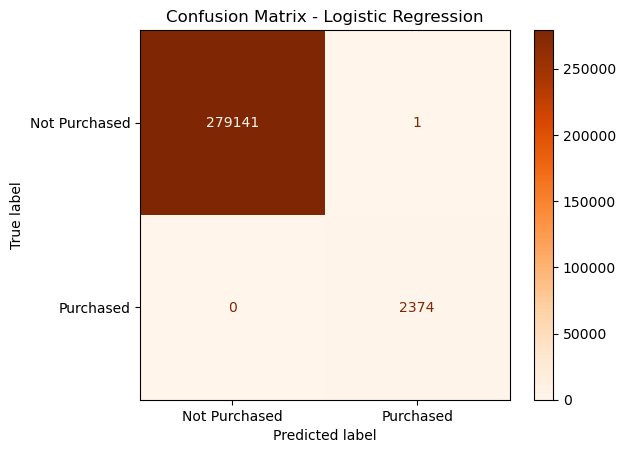

=== Decision Tree ===
Accuracy: 0.9941104590858069
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    279142
           1       0.86      0.36      0.51      2374

    accuracy                           0.99    281516
   macro avg       0.93      0.68      0.75    281516
weighted avg       0.99      0.99      0.99    281516



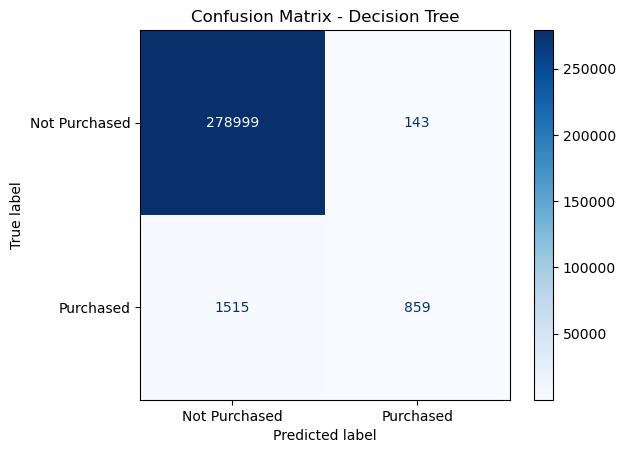

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Evaluation: Logistic Regression ===
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Not Purchased", "Purchased"])
disp_lr.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# === Evaluation: Decision Tree ===
print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Not Purchased", "Purchased"])
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Decision Tree")
plt.show()


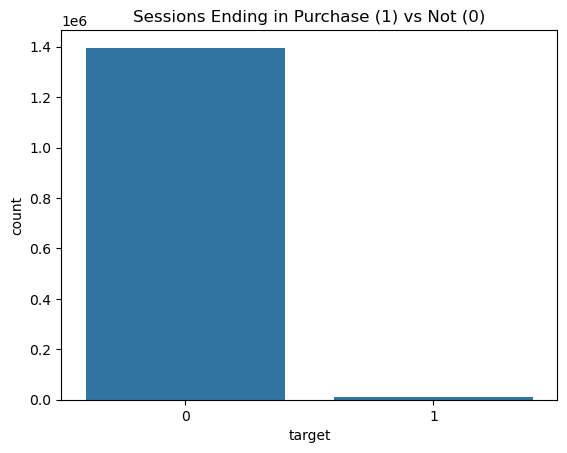

In [17]:
sns.countplot(data=session_df, x='target')
plt.title("Sessions Ending in Purchase (1) vs Not (0)")
plt.show()


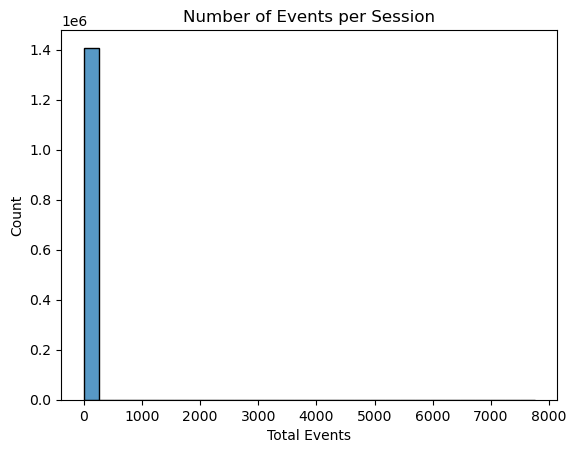

In [18]:
sns.histplot(session_df['total_events'], bins=30)
plt.title("Number of Events per Session")
plt.xlabel("Total Events")
plt.show()


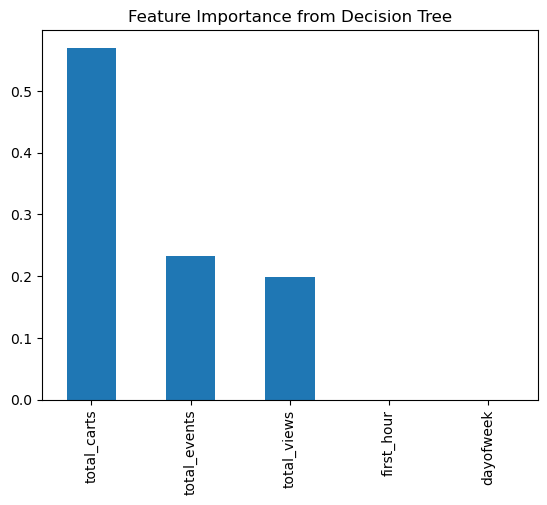

In [19]:
feature_importance = pd.Series(dtree.feature_importances_, index=features).sort_values(ascending=False)
feature_importance.plot(kind='bar')
plt.title("Feature Importance from Decision Tree")
plt.show()


In [20]:
# Filter only views
views = events[events['event'] == 'view']

# Count views per item per category
popular_items = views.groupby(['categoryid', 'itemid']).size().reset_index(name='views')
popular_items = popular_items.sort_values(['categoryid', 'views'], ascending=[True, False])


In [21]:
# Pick a random visitor
visitor = session_df.sample(1)['visitorid'].values[0]

# Get events for that visitor
visitor_events = events[events['visitorid'] == visitor]

# Check if there are any category interactions
if not visitor_events['categoryid'].dropna().empty:
    # Get the most interacted category
    top_cat = visitor_events['categoryid'].mode().values[0]

    # Recommend top 5 most viewed items from that category
    recommended_items = popular_items[popular_items['categoryid'] == top_cat].head(5)

    print(f"Visitor ID: {visitor}")
    print(f"Top Category Interacted: {top_cat}")
    print("Recommended Items:")
    print(recommended_items[['itemid', 'views']])
else:
    print(f"Visitor ID: {visitor}")
    print("No category interactions found for this visitor.")


Visitor ID: 363297
Top Category Interacted: 1186
Recommended Items:
       itemid  views
26228  348596    369
26168  256695    313
26054  108457    280
26071  132347    276
26078  143689    233


### Conclusion

In this project, we built a session-based product recommendation pipeline using interpretable machine learning models. Key steps included:

- Cleaning and preprocessing session data
- Engineering relevant session-level features
- Training and evaluating Decision Tree and Logistic Regression classifiers

This serves as a foundational baseline for building more advanced recommendation systems using session data.
